<div align="center"><h1>Case Study: Streaming Provider</h1>
<h3>By: Wiebke Plückhahn, 10/27/2022</h3></div>

In this fictitious case study, a streaming provider for movies wants to expand its offering. In order to promote customer loyalty, the company wants to include movies in its offer that will presumably be well rated by users.  

The MovieLens 100k dataset (available at https://grouplens.org/datasets/movielens/100k/) is used, which consists of 100 000 ratings from 943 users on 1682 movies. Each user has rated at least 20 movies and some demographic information (e.g. age and gender) is also stored in the dataset.
The dataset, which is made available for download by the University of Minnesota, contains several text files. In this case study, the following tables were used: u.data, u.item, u.user.

In order to make recommendations on what type of movies would be best to include in the collection, conjoint analyses on movie and watch-event (user) level are first performed. Here, individual genres as well as profiles (combinations of different genres) are considered.
To round off the recommendation and to enable an informed decision, a customer base analysis is also carried out. Therefor, a cluster analysis is performed using the k-means algorithm. Then, the user behavior of the different user groups is explored. The MovieLens data is supposed to represent the data collected by the streaming provider so far.

Reference:  
F. Maxwell Harper and Joseph A. Konstan. 2015. the MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI: http://dx.doi.org/10.1145/2827872


In [1]:
#Setting up the environment
%pip install researchpy
from google.cloud.bigquery import Client, QueryJobConfig
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import researchpy as rp
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

  Using cached researchpy-0.3.5-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


<h2>Conjoint Analysis 1</h2>
<h3>Movie Level</h3>

I used BigQuery and SQL to join and transform data for the conjoint analysis. The resulting data frame consists of:  
- The genres from the u.item table joined on the u.data table
- Grouping by movie and selecting columns, so that a data frame results that contains the average rating per movie and 0/1 coded genre-variables
- Release dates of movies were stripped to year and binned into decades
- Then, profile aliases were generated by casting genre coding as strings and concatinating strings so that each movie corresponds to a profile of genre and year
- Data was then grouped by profile, resulting in 362 unique profiles that cover each of the 1682 movies
- A rank was generated based on the average rating of each movie profile.  
  
The resulting data table (df) was then imported:

In [2]:
#Importing data from BigQuery
#Note: This Notebook was originally hosted on Google Cloud Vertex AI Workbench
client = Client()
query = """SELECT * FROM `conjoint-366108.movielens.myConjointData`"""
job = client.query(query)
df = job.to_dataframe()
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_rating       362 non-null    float64
 1   Action           362 non-null    float64
 2   Adventure        362 non-null    float64
 3   Animation        362 non-null    float64
 4   Children_s       362 non-null    float64
 5   Comedy           362 non-null    float64
 6   Crime            362 non-null    float64
 7   Documentary      362 non-null    float64
 8   Drama            362 non-null    float64
 9   Fantasy          362 non-null    float64
 10  Film_Noir        362 non-null    float64
 11  Horror           362 non-null    float64
 12  Musical          362 non-null    float64
 13  Mystery          362 non-null    float64
 14  Romance          362 non-null    float64
 15  Sci_Fi           362 non-null    float64
 16  Thriller         362 non-null    float64
 17  War             

,avg_rating,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror_str,Musical_str,Mystery_str,Romance_str,Sci_Fi_str,Thriller_str,War_str,Western_str,year_range_str,profile
0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0000000100000000000
1,3.555556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0000000000100000000


<h3>Analysis - Individual Features</h3>
I used a multiple linear regression model to compute utility scores for each genre. However, it is important to consider that movies were nested in profiles, therefore data was aggregated and a slight distortion of coefficients might occur as not all profiles contain the same number of movies. This is a minor bias that I control for by performing an additional unnested analysis in the user level section. 

In [3]:
#Linear Regression to compute utility scores of each genre
lr=LinearRegression()

X = df[['Action','Adventure','Animation','Children_s','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller',\
        'War','Western','Thirties','Fourties','Fifties','Sixties','Seventies','Eighties','Nineties']]
Y = df[['avg_rating']]

#Standarization to obtain comparable values
scaler=StandardScaler().fit(X)
stand_X=scaler.transform(X)
scaler=StandardScaler().fit(Y)
stand_Y=scaler.transform(Y)

lr.fit(stand_X, stand_Y)
print("R2 score is:", lr.score(stand_X, stand_Y))
coef = lr.coef_

#Save results in easy to read data frame
df_coef = pd.DataFrame(
    
    {"Attribute" :['Action','Adventure','Animation','Children_s','Comedy','Crime','Documentary','Drama','Fantasy',\
                   'Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller',\
                   'War','Western','Thirties','Fourties','Fifties','Sixties','Seventies','Eighties','Nineties'],
      "Weight" : coef.tolist()[0]})
df_coef

R2 score is: 0.3110737270938254


,Attribute,Weight
0,Action,-0.053754
1,Adventure,0.137542
2,Animation,0.162569
3,Children_s,-0.175035
4,Comedy,0.148740
5,Crime,0.079198
6,Documentary,0.030576
7,Drama,0.196242
8,Fantasy,0.008157
9,Film_Noir,0.098600


The regression (or utility scores, respectively) show the relative importance of each genre/release decade for the average rating of the profiles (and movies). Attributed with values higher than zero promote a good rating, attributes with negative utility scores are detrimental to the ranking by users. Note that the coefficients range between -1 and 1 and are standardized, thus comparable to each other. A first look indicates that drama movies appear to be very popular but we will find out more details by visualizing the data:

<h3>Visualization</h3>
First, we compare the global attribute categories, namely, genres and decades of release. Quite surprisingly, the decade of release seems to be just as crucial to the rating as the genre, if not a tiny bit more so:

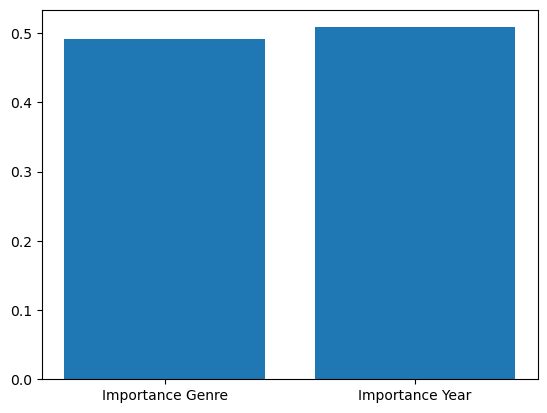

Importance Genre: 0.49165775539474066 Importance Year: 0.5083422446052595


In [4]:
#Relative importance of attribute categories
sum_genre = df_coef.head(18).Weight.abs().sum()/18
sum_year = df_coef.tail(7).Weight.abs().sum()/7
rel_genre = sum_genre/(sum_genre+sum_year)
rel_year = sum_year/(sum_genre+sum_year)

#Bar chart year vs. genre
heights = [rel_genre, rel_year]
bars= ('Importance Genre', 'Importance Year')
y_pos= np.arange(len(bars))
plt.bar(y_pos, heights)
plt.xticks(y_pos, bars)
plt.show()
print("Importance Genre:",rel_genre, "Importance Year:",rel_year)

But to what extent the decade influences the rating cannot be seen from the figure above. For that, we dive a bit more into detail by examining the scatter plot of decade vs. utility score:

<AxesSubplot:xlabel='year', ylabel='Weight'>

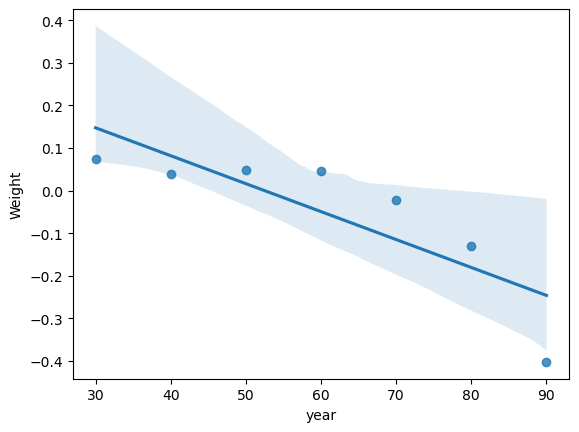

In [5]:
#Scatter utility score by decade
df_year = df_coef.tail(7).reset_index().drop(columns=['index'])
df_year['year'] = [30, 40, 50, 60, 70, 80, 90]
sns.regplot(data=df_year, x='year', y='Weight')

A polynomial, almost linear trend emerges with our first relevant finding:  
**Apparently, older films are rated better!**  
**However, movies from the Thirties to Sixties are rated similarly well, the decline starts with the Seventies...**  
  
Now, on to the genres. Let's explore which features seem to particularly benefit a movie's rating.

<AxesSubplot:xlabel='Attribute'>

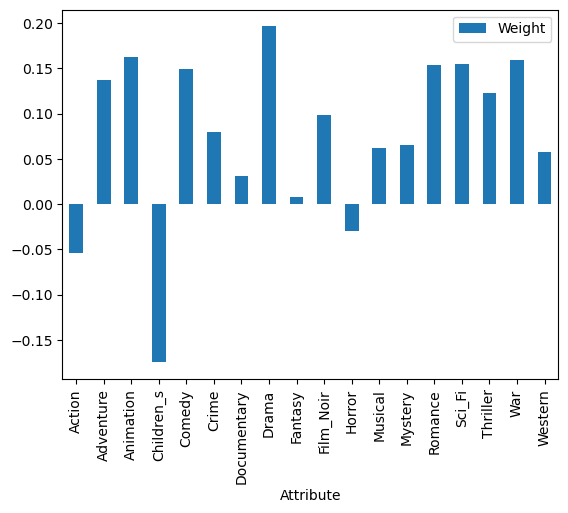

In [6]:
#Bar chart genre
df_genre = df_coef.head(18)
df_genre.plot.bar(x='Attribute', y='Weight')

As seen in the table, movies corresponding to the **Drama** genre were rated best. Therefore, this genre is a good candidate for the inclusion of further movies.  
Also, utility scores of the genres of **Animation, War, Sci Fi, Romance, Comedy, and Adventure** are considerably high and indicators for good ratings.  
The company should refrain from adding more **Childen's, Action, and Horror** movies since these are rated particularly poorly on average.
This is a solid first finding, however, it is possible for a movie to fit multiple genres. What movies should the company add? Only films from the Drama category? Or perhaps movies that correspond to the genres of Drama, Animation AND War, for example, are particularly well rated?  
  
Also, the decade of publication is not included in these considerations. It is time not to consider the attributes individually detached from each other, but to combine them.
This is where the profiles come into play. Each combination of different genres + decades available in the data set forms its own profile. Each profile can be represented by only one, but also by several films.

<h3>Analysis - Profile Features</h3>
For this analysis, no linear regression is to be performed. Though linear regression would provide utility scores for the average rating, we instead use the average ratin itself that already constitutes a sufficient utility score. This approach is especially relevant, as I cross-check profile data from conjoint analysis 2 with results this analysis yields, therefore generating robust recommendations that perform well in both approaches.

By transposing the data frame, we get a good overview of the top 5 rated profiles:

In [7]:
# which profiles are ranked best? --> in this case we don't need a regression model
df_profiles = df.sort_values('avg_rating', ascending=False).head(5)
display(df_profiles.transpose())

,233,10,310,38,92
avg_rating,5.0,5.0,4.491071,4.45679,4.358491
Action,0.0,0.0,0.0,0.0,1.0
Adventure,1.0,0.0,0.0,0.0,1.0
Animation,0.0,0.0,1.0,0.0,0.0
Children_s,1.0,0.0,0.0,0.0,0.0
Comedy,0.0,0.0,1.0,0.0,0.0
Crime,0.0,1.0,0.0,0.0,0.0
Documentary,0.0,0.0,0.0,0.0,0.0
Drama,0.0,1.0,0.0,1.0,0.0
Fantasy,1.0,0.0,0.0,0.0,0.0


However, this table is not very convenient to read so here is a bar chart summarizing the average rating scores of the top 5 profiles:

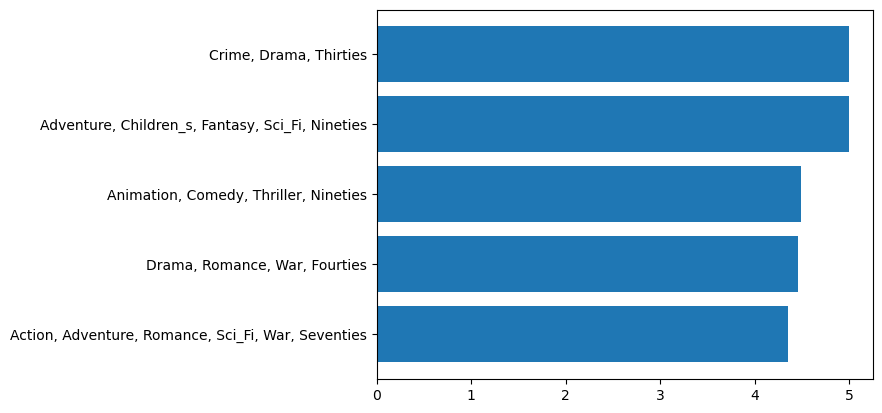

In [8]:
#bar chart
df_profiles['prof_descr']=['Crime, Drama, Thirties', 
                           'Adventure, Children_s, Fantasy, Sci_Fi, Nineties', 
                           'Animation, Comedy, Thriller, Nineties',
                          'Drama, Romance, War, Fourties',
                          'Action, Adventure, Romance, Sci_Fi, War, Seventies']

profile=df_profiles['prof_descr']
weight = df_profiles['avg_rating']
plt.barh(profile,weight)
plt.gca().invert_yaxis()
plt.show()

Now, this is quite surprising! From the individual feature analysis, we already now that the Drama genre and older movies score quite well, but, apparently, the movies combining these categories are rated best when they also include a crime plot.  
Good to know!  
Also, what is really astonishing is that the most popular profile contains the genre and release decade that in the individual attribute analysis scored worst: Children's movies from the Eighties! But, when combined with Adventure, Fantasy and Sci Fi, these movies seem to be a hit - What a prime example of outliers and how the big picture should always be considered.


All in all, the company really should think about adding movies corresponding to these 5 attribute combinations.

So, this is great. We can already make some decent recommendations. However, the analyses up to this point have not taken into account how often movies from each profile are watched at all and that some users might use the streaming provider way more frequently than others. Therefore, to complete the recommendation, an additional conjoint analysis on user level is now to be performed.
<h2>Conjoint Analysis 2</h2>
<h3>Watch-Events (User Level)</h3>
Once again, I used BigQuery and SQL to join and transform data for the conjoint analysis. The resulting data frame consists of: 

- The genres from the u.item table joined on the u.data table
- Demographic information from the u.user table joined on this table
- Again, profile aliases were generated by casting genre coding as strings and concatinating strings so that each watch event corresponds to a profile of genre and year
  
The resulting data table (df2), that contains each watch-event with rating, movie, and user information was then imported:

In [9]:
#Data frame for watch-event conjoint
client = Client()
query = """SELECT * FROM `conjoint-366108.movielens.myConjointData_watchevents`"""
job = client.query(query)
df2 = job.to_dataframe()
df2 = df2.loc[df2["unknown"] != 1]
df2.drop(columns=['movie_ID_1' , 'releaseDate', 'videoreleasedate', 'IMDbURL', 'unknown', 'user_ID_1', 'movieID'], inplace=True)
df2.info()
df2.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 10 to 99999
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_ID      99990 non-null  int64 
 1   movie_ID     99990 non-null  int64 
 2   rating       99990 non-null  int64 
 3   timestamp    99990 non-null  int64 
 4   title        99990 non-null  object
 5   Action       99990 non-null  int64 
 6   Adventure    99990 non-null  int64 
 7   Animation    99990 non-null  int64 
 8   Children_s   99990 non-null  int64 
 9   Comedy       99990 non-null  int64 
 10  Crime        99990 non-null  int64 
 11  Documentary  99990 non-null  int64 
 12  Drama        99990 non-null  int64 
 13  Fantasy      99990 non-null  int64 
 14  Film_Noir    99990 non-null  int64 
 15  Horror       99990 non-null  int64 
 16  Musical      99990 non-null  int64 
 17  Mystery      99990 non-null  int64 
 18  Romance      99990 non-null  int64 
 19  Sci_Fi       99990 non-n

,user_ID,movie_ID,rating,timestamp,title,Action,Adventure,Animation,Children_s,Comedy,...,occupation,zipcode,thirties,fourties,fifties,sixties,seventies,eighties,nineties,profile
10,234,1455,2,892318158,Outlaw& The (1943),0,0,0,0,0,...,retired,94702,0,1,0,0,0,0,0,0000000000000000014
11,694,1455,3,875727061,Outlaw& The (1943),0,0,0,0,0,...,programmer,6365,0,1,0,0,0,0,0,0000000000000000014


<h3>Analysis - Individual Features</h3>
Once again, a multiple linear regression model is fitted to determine the utility scores of each genre, this time considering the frequency of each genre (and frequency with which each movies are viewed).

In [10]:
lr=LinearRegression()
X = df2[['Action','Adventure','Animation','Children_s','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller',\
        'War','Western','thirties','fourties','fifties','sixties','seventies','eighties', 'nineties']]
Y = df2[['rating']]

#Standarization of features
scaler=StandardScaler().fit(X)
stand_X=scaler.transform(X)
scaler=StandardScaler().fit(Y)
stand_Y=scaler.transform(Y)

lr.fit(stand_X, stand_Y)
print("R2 score is:", lr.score(stand_X, stand_Y))
coef = lr.coef_

#Save results in data frame
df_coef = pd.DataFrame(
    
    {"Attribute" :['Action','Adventure','Animation','Children_s','Comedy','Crime','Documentary','Drama','Fantasy',\
                   'Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller',\
                   'War','Western','Thirties','Fourties','Fifties','Sixties','Seventies','Eighties', 'Nineties'],
      "Weight" : coef.tolist()[0]})
df_coef

R2 score is: 0.06517652234233529


,Attribute,Weight
0,Action,-0.017627
1,Adventure,0.009941
2,Animation,0.069817
3,Children_s,-0.054327
4,Comedy,-0.011155
5,Crime,0.029576
6,Documentary,0.029005
7,Drama,0.121503
8,Fantasy,-0.017583
9,Film_Noir,0.023547


First and foremost, the R2 score of the unnested data analysis is way smaller than the one of the aggregated profile analysis (R2 = 0.31), meaning that the aggregated approach fits the data considerably better.  
By the first look, the resulting utility scores are slightly different than in the profile based analysis. We will now explore similarities and differences. First, we again consider relative importance of genre versus release decade for the rating of each watch event.
<h3>Visualization</h3>

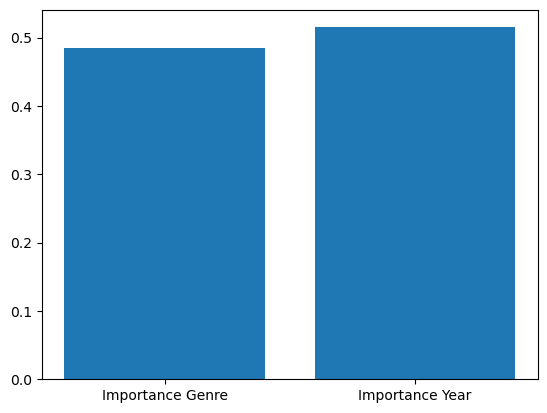

Importance Genre: 0.4848235547365965 Importance Year: 0.5151764452634036


In [11]:
#Relative importance of attribute categories
sum_genre = df_coef.head(18).Weight.abs().sum()/18
sum_year = df_coef.tail(8).Weight.abs().sum()/8
rel_genre = sum_genre/(sum_genre+sum_year)
rel_year = sum_year/(sum_genre+sum_year)

#Bar chart year vs. genre
heights = [rel_genre, rel_year]
bars= ('Importance Genre', 'Importance Year')
y_pos= np.arange(len(bars))
plt.bar(y_pos, heights)
plt.xticks(y_pos, bars)
plt.show()
print("Importance Genre:",rel_genre, "Importance Year:",rel_year)

We notice the same pattern as in analysis 1: both feature categories seem to be equally important to a movies overall rating. Lets explore both categories in more detail.  
First, the release decade:

<AxesSubplot:xlabel='year', ylabel='Weight'>

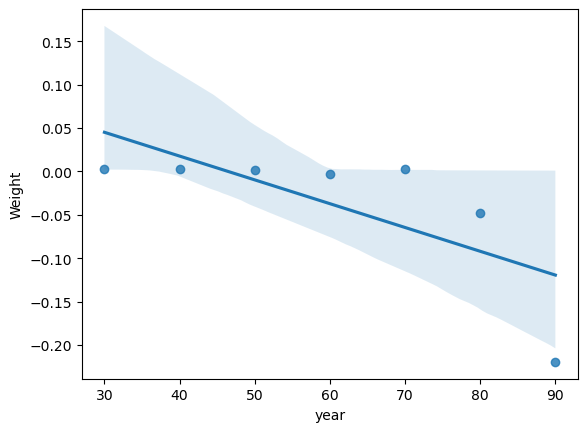

In [12]:
#Scatter year
df_year = df_coef.tail(7).reset_index().drop(columns=['index'])
df_year['year'] = [30, 40, 50, 60, 70, 80, 90]
sns.regplot(data=df_year, x='year', y='Weight')

The plot again shows a slightly linear negative relationship of release decade and utility score for rating.  
**Again, older movies tend to be rated best.**  
However, one big difference emerges compared to the aggregated solution: Movies from the **Seventies** are now rated equally well as the really old-school movies and the drop starts with the Eighites. This does not mean that the company should add movies from the Seventies, but it does mean that some really great and frequently watched movies were produced in the Seventies!  
Let's explore the genre.

<AxesSubplot:xlabel='Attribute'>

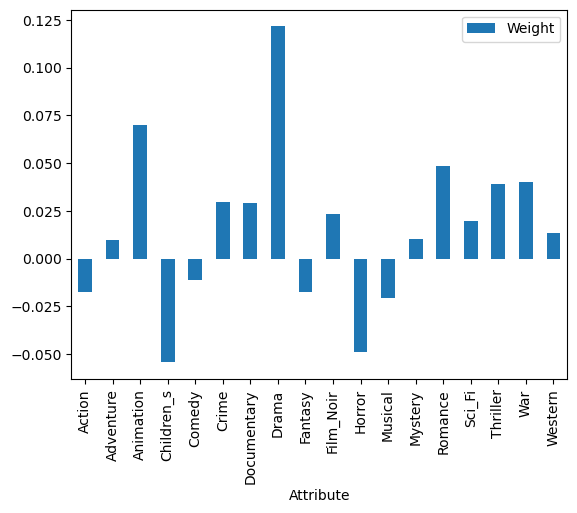

In [13]:
#Bar chart genre
df_genre = df_coef.head(18)
df_genre.plot.bar(x='Attribute', y='Weight')

In general, coefficients are smaller than in the first analysis. The relative pattern, however, is quite congruent: Movies from the genres **Drama, Anmation, Romance, Sci Fi, and War** are the top performers. When looking at the watch events, **Thrillers** now also are rated pretty well.  
Not recommended for further expansion of the movie range are, once again, movies from the genres **Children's, Horror, and Action**, now complemented by **Musical and Fantasy** movies.  

Well, this is quite empowering and validating the results from the first analysis. Let's, once again, look at the combination of different genres.


<h3>Analysis - Profile Features</h3>
In contrast to the first analysis, each profile is now represented multiple times and therefore a regression model is needed to determine the utility scores for each profile.

In [14]:
#First, as the profile abbreviation is a string variable, we need to dummy code each profile present in the data
df_profile_dummies=pd.get_dummies(df2, columns=['profile'])
profiles = list(df_profile_dummies)[35:]

#Then, the linear regression model can be defined and fitted
lr=LinearRegression()
X = df_profile_dummies[profiles]
Y = df_profile_dummies[['rating']]

#Standarization of features
scaler=StandardScaler().fit(X)
stand_X=scaler.transform(X)
scaler=StandardScaler().fit(Y)
stand_Y=scaler.transform(Y)

lr.fit(stand_X, stand_Y)
print("R2 score is:", lr.score(stand_X, stand_Y))
coef = lr.coef_

#Save results in data frame
df_coef = pd.DataFrame({"Attribute" : profiles, "Weight" : coef.tolist()[0]})
df_coef_top5=df_coef.sort_values('Weight', ascending=False).head(5)
df_coef_top5

R2 score is: 0.11610155690951651


,Attribute,Weight
74,profile_0000000100000000009,0.187649
88,profile_0000000100000100009,0.127729
73,profile_0000000100000000008,0.109061
334,profile_1100000000000110107,0.100338
304,profile_1000010100000000007,0.096098


As the last number in the profile ID states the release decade, we can already see that other profiles take the top 5 places than with the profile-centered approach. Let's quickly visualize the utility scores:
<h3>Visualization</h3>

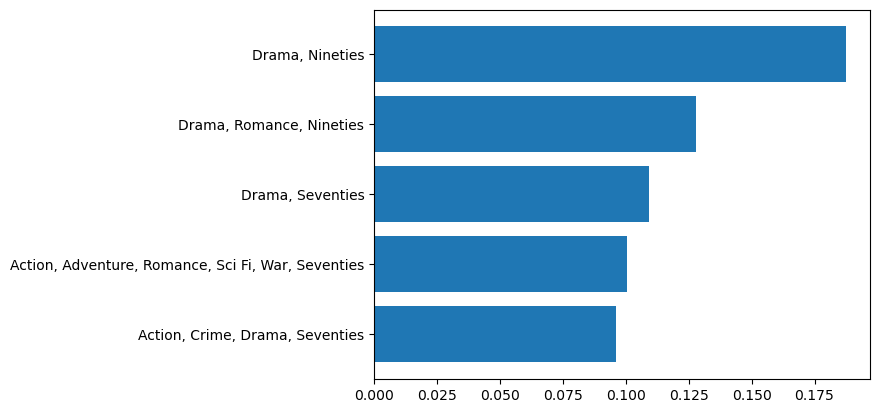

In [15]:
#bar chart
df_coef_top5['prof_descr']=['Drama, Nineties', 
                           'Drama, Romance, Nineties', 
                           'Drama, Seventies',
                            'Action, Adventure, Romance, Sci Fi, War, Seventies',
                            'Action, Crime, Drama, Seventies']

profile=df_coef_top5['prof_descr']
weight = df_coef_top5['Weight']
plt.barh(profile,weight)
plt.gca().invert_yaxis()
plt.show()

Interesting! The top 5 feature combinations are quite different compared to the ones from the profile centered approach. The only exception: movies that fit in the category **Action, Adventure, Romance, Sci Fi, War from the Seventies** - that might be Star Wars? Let's check what movies from this profiles are already listed by the company, as additions to this profile segment might be a good idea.  

In [16]:
df2.loc[df2['profile']=="1100000000000110106", ['title']].groupby('title').sum()

""
title


Indeed, guessed correctly! And it's the only movie with this combination of features, so adding similar movies like Star Wars might be a good idea.  
Also, **Drama** is quite frequently represented in the profiles on the watch event level. To explore this a little more, we will cross check and compare the ratings of each top 5 profiles from the profile- and watch-event-centered analyses.

In [17]:
#First, generate data frames with profile key, avg rating/utility score, and comparative rank for profile centered 
#and watch-event data
weights_profiles=df[['profile', 'avg_rating']].sort_values('avg_rating', ascending=False).reset_index().drop(columns=['index'])
weights_profiles['rank']=weights_profiles['avg_rating'].rank(ascending=False)
weights_watch_events=df_coef.sort_values('Weight', ascending=False).reset_index().drop(columns='index')
weights_watch_events['rank']=weights_watch_events['Weight'].rank(ascending=False)

#Now, check rank of top 5 profiles in the respective other approach
print("Ranks of profiles from watch-event data in profile approach")
print()
print("First profile (Drama, Nineties):",\
      weights_profiles.loc[weights_profiles['profile']=='0000000100000000009', ['rank']].reset_index().at[0,'rank'])
print("Second profile (Drama, Romance, Nineties):",\
      weights_profiles.loc[weights_profiles['profile']=='0000000100000100009', ['rank']].reset_index().at[0,'rank'])
print("Third profile (Drama, Seventies):",\
      weights_profiles.loc[weights_profiles['profile']=='0000000100000000008', ['rank']].reset_index().at[0,'rank'])
print("Fourth profile (Action, Adventure, Romance, Sci Fi, War, Seventies):",\
      weights_profiles.loc[weights_profiles['profile']=='1100000000000110107', ['rank']].reset_index().at[0,'rank'])
print("Fifth profile (Action, Crime, Drama, Seventies):",\
      weights_profiles.loc[weights_profiles['profile']=='1000010100000000007', ['rank']].reset_index().at[0,'rank'])
print()
print()
print("Ranks of profiles from profile-centered data in watch-event approach")
print()
print("First profile (Crime, Drama, Thirties):",\
      weights_watch_events.loc[weights_watch_events['Attribute']=='profile_0101000010000010009', \
                               ['rank']].reset_index().at[0,'rank'])
print("Second profile (Adventure, Children_s, Fantasy, Sci_Fi, Nineties):",\
      weights_watch_events.loc[weights_watch_events['Attribute']=='profile_0000010100000000003', \
                               ['rank']].reset_index().at[0,'rank'])
print("Third profile (Animation, Comedy, Thriller, Nineties):",\
      weights_watch_events.loc[weights_watch_events['Attribute']=='profile_0010100000000001009', \
                               ['rank']].reset_index().at[0,'rank'])
print("Fourth profile (Drama, Romance, War, Fourties):",\
      weights_watch_events.loc[weights_watch_events['Attribute']=='profile_0000000100000100104', \
                               ['rank']].reset_index().at[0,'rank'])
print("Fifth profile (Action, Adventure, Romance, Sci_Fi, War, Seventies):",\
      weights_watch_events.loc[weights_watch_events['Attribute']=='profile_1100000000000110107', \
                               ['rank']].reset_index().at[0,'rank'])

Ranks of profiles from watch-event data in profile approach

First profile (Drama, Nineties): 231.0
Second profile (Drama, Romance, Nineties): 205.0
Third profile (Drama, Seventies): 186.0
Fourth profile (Action, Adventure, Romance, Sci Fi, War, Seventies): 5.0
Fifth profile (Action, Crime, Drama, Seventies): 11.0


Ranks of profiles from profile-centered data in watch-event approach

First profile (Crime, Drama, Thirties): 216.0
Second profile (Adventure, Children_s, Fantasy, Sci_Fi, Nineties): 247.0
Third profile (Animation, Comedy, Thriller, Nineties): 59.0
Fourth profile (Drama, Romance, War, Fourties): 25.0
Fifth profile (Action, Adventure, Romance, Sci_Fi, War, Seventies): 4.0


The cross-validation yields some differences and some similarities. Taken together, the following combination of features should be considered for inclusion of further movies:
- Action, Adventure, Romance, Sci_Fi, War, Seventies
- Action, Crime, Drama, Seventies
- Drama, Romance, War, Fourties

For the first category, we already know that Star Wars is the only movie the provider streams right now.  
Prototypes for the second and third are:

In [18]:
print("Prototypes for the features Action, Crime, and Drama from the Seventies:")
display(df2.loc[df2['profile']=="1000010100000000007", ['title']].groupby('title').sum())
print("Prototypes for the features Drama, Romance, and War from the Fourties:")
df2.loc[df2['profile']=="0000000100000100104", ['title']].groupby('title').sum()

Prototypes for the features Action, Crime, and Drama from the Seventies:


""
title
Godfather& The (1972)
Godfather: Part II& The (1974)


Prototypes for the features Drama, Romance, and War from the Fourties:


""
title
Casablanca (1942)


<h2>Customer Base Analysis</h2>
The results so far already allow for some profound recommendations, however, as the user base is quite large, it is likely that not all users would favour the same movies.  
Therefore, the following section provides an analysis of the watch behavior of different target groups.
First, these customer groups are to be detected. I used a k-means clustering approach that considers user-level data. Demographic information on age, gender and profession as well as usage behavior was fed in. For this, the average frequency of each genre assigned to the movies the user watches was considered for each user.  

In the next piece of code, the watch-event data is grouped by the user, so that each line in the data frame contains data of one user. Also, some categorical variables need to be dummy coded for further analysis.

In [19]:
#Dummy-coding gender and profession
df_clus = pd.get_dummies(df2, columns=['gender', 'occupation'])
df_clus = df_clus.drop(columns=['movie_ID', 'timestamp', 'title', 'zipcode', 'gender_M'])

#generating user-level data frame with averagely watched movie genres and ratings
df_clus=df_clus.groupby(by='user_ID').mean()
df_clus.head(2)

,rating,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
user_ID,,,,,,,,,,,,,,,,,,,,,
1,3.608856,0.276753,0.154982,0.044280,0.092251,0.335793,0.092251,0.01845,0.394834,0.007380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.709677,0.161290,0.048387,0.016129,0.064516,0.258065,0.145161,0.00000,0.564516,0.016129,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, on to the clustering. As the k means algorithm runs on a set number of resulting clusters, the optimal amount of clusters needs to be figured out first. I did this by cross-checking the two most common methods to determine the k clusters: Elbow and Silhouette plotting.

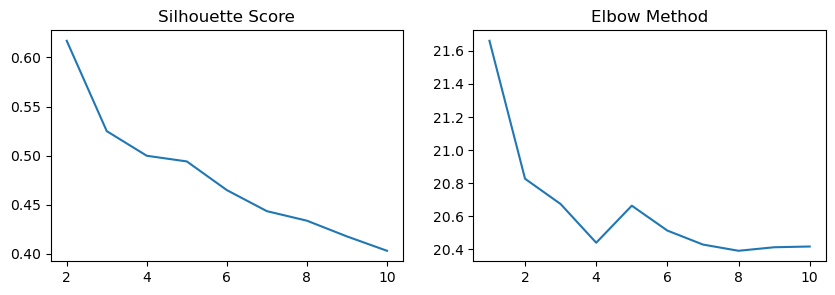

In [20]:
#Data normalization
X = df_clus.values[:,1:]
df_clus_norm = StandardScaler().fit_transform(X)

#determine optimal number of clusters
#Silhuouette score
sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

k=[*range(2,11,1)]

#Elbow method
def calculate_WSS(points, kmax):
  sse = []
  for l in range(1, kmax+1):
    kmeans = KMeans(n_clusters = l).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2    
    sse.append(curr_sse)
  return sse

elbow=calculate_WSS(X,10)
l=[*range(1,11,1)]

#Plotting
fig=plt.figure()
fig.set_size_inches(10, 3)
ax=fig.add_subplot(121)
ax.set(title="Silhouette Score")
ax.plot(k, sil)
ax=fig.add_subplot(122)
ax.set(title="Elbow Method")
ax.plot(l, elbow)
plt.show()

Both the Elbow as well as the Silhouette Plot show that there seem to be **two target groups** in the customer base. However, these techniques do not indicate the differences in the clusters, therefor the final k means estimation is to be performed that assigns each user to one of the two groups.  
Also, to get a feeling for the sample, some basic descriptive statistics are presented.

In [21]:
#Cluster data with k-means
k_means=KMeans(n_clusters=2, random_state=0)
k_means.fit(X)
labels = k_means.labels_
df_clus["Clus_km"] = labels
display(df_clus.head(2))
df_clus[['gender_F', 'age', 'rating', 'Clus_km']].describe()

,rating,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,Clus_km
user_ID,,,,,,,,,,,,,,,,,,,,,
1,3.608856,0.276753,0.154982,0.044280,0.092251,0.335793,0.092251,0.01845,0.394834,0.007380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,3.709677,0.161290,0.048387,0.016129,0.064516,0.258065,0.145161,0.00000,0.564516,0.016129,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


,gender_F,age,rating,Clus_km
count,943.000000,943.000000,943.000000,943.000000
mean,0.289502,34.051962,3.588165,0.352068
std,0.453772,12.192740,0.445240,0.477868
min,0.000000,7.000000,1.493088,0.000000
25%,0.000000,25.000000,3.323054,0.000000
50%,0.000000,31.000000,3.620690,0.000000
75%,1.000000,43.000000,3.869565,1.000000
max,1.000000,73.000000,4.869565,1.000000


65% of the users belong to the first cluster (cluster 0), while the remaining 35 % belong to the second cluster (cluster 1).
29% of the whole customer base are female, the mean age is 34 years (SD = 12) with a range of 7 (this very likely is a miscoded datapoint) up to 73 years.
The average rating every user has rated all watched movies on average is 3.6 out of 5 (SD = 0.4). Now, let's dive a bit deeper into differences between the two target groups by juxtaposing their characteristics.
<h3>Visualization</h3>

In [22]:
#Grouping the data by cluster to compare mean values of each attribute
df_clus_mean = df_clus.groupby('Clus_km').mean()
df_clus_mean['cluster']=df_clus_mean.index
df_clus_mean=df_clus_mean.transpose().reset_index()
df_clus_mean.rename(columns={'index':'Attribute', 0:'Cluster_0', 1:'Cluster_1'}, inplace=True)
display(df_clus_mean)

#create df for visualization of genres of movies
df_clus_mean_genre=pd.concat([df_clus_mean.iloc[1:19], df_clus_mean.iloc[20:27]])
df_clus_mean_genre.reset_index().drop('index', axis=1, inplace=True)

#create df for visualization of demographic variables
df_clus_mean_demogr = df_clus_mean.loc[28:49]

Clus_km,Attribute,Cluster_0,Cluster_1
0,rating,3.561753,3.636772
1,Action,0.279966,0.225586
2,Adventure,0.140814,0.110396
3,Animation,0.035349,0.023305
4,Children_s,0.067532,0.056167
5,Comedy,0.282484,0.267921
6,Crime,0.088725,0.085399
7,Documentary,0.006457,0.007497
8,Drama,0.387601,0.471092
9,Fantasy,0.010983,0.010294


By the first look, only minor differences in the attributes occur, the most significant difference might be the age and some related occupations (student vs. retired). Let's explore this a little more in depth.
As the company is most interested in what movies to add, I first compare the watch behavior of the two target groups. Let's first test for significance of differences between the two cluster by performing independet t-tests.

In [23]:
labels = df_clus_mean_genre['Attribute']
for attr in labels:
    summary, results = rp.ttest(group1= df_clus[attr][df_clus['Clus_km'] == 0], group1_name= "Cluster 0",
                                group2= df_clus[attr][df_clus['Clus_km'] == 1], group2_name= "Cluster 1")
    if results.at[3, 'results'] < 0.05:
        print("t-test for",attr,":")
        display(results.iloc[0:4])

t-test for Action :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0544
1,Degrees of freedom =,941.0000
2,t =,6.3328
3,Two side test p value =,0.0000


t-test for Adventure :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0304
1,Degrees of freedom =,941.0000
2,t =,5.6341
3,Two side test p value =,0.0000


t-test for Animation :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0120
1,Degrees of freedom =,941.0000
2,t =,4.5556
3,Two side test p value =,0.0000


t-test for Children_s :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0114
1,Degrees of freedom =,941.0000
2,t =,2.7298
3,Two side test p value =,0.0065


t-test for Drama :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0835
1,Degrees of freedom =,941.0000
2,t =,-9.5752
3,Two side test p value =,0.0000


t-test for Film_Noir :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0063
1,Degrees of freedom =,941.0000
2,t =,-4.4759
3,Two side test p value =,0.0000


t-test for Horror :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0236
1,Degrees of freedom =,941.0000
2,t =,5.2082
3,Two side test p value =,0.0000


t-test for Mystery :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0150
1,Degrees of freedom =,941.0000
2,t =,-4.2512
3,Two side test p value =,0.0000


t-test for Romance :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0137
1,Degrees of freedom =,941.0000
2,t =,-2.5172
3,Two side test p value =,0.0120


t-test for Sci_Fi :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0358
1,Degrees of freedom =,941.0000
2,t =,7.2669
3,Two side test p value =,0.0000


t-test for Thriller :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0248
1,Degrees of freedom =,941.0000
2,t =,3.2502
3,Two side test p value =,0.0012


t-test for War :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0142
1,Degrees of freedom =,941.0000
2,t =,-4.3738
3,Two side test p value =,0.0000


t-test for thirties :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0054
1,Degrees of freedom =,941.0000
2,t =,-4.2212
3,Two side test p value =,0.0000


t-test for fourties :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0086
1,Degrees of freedom =,941.0000
2,t =,-4.6767
3,Two side test p value =,0.0000


t-test for fifties :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0160
1,Degrees of freedom =,941.0000
2,t =,-6.1252
3,Two side test p value =,0.0000


t-test for sixties :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0112
1,Degrees of freedom =,941.0000
2,t =,-4.6608
3,Two side test p value =,0.0000


t-test for eighties :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0135
1,Degrees of freedom =,941.0000
2,t =,2.3285
3,Two side test p value =,0.0201


t-test for nineties :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.0326
1,Degrees of freedom =,941.0000
2,t =,2.3464
3,Two side test p value =,0.0192


Wow! Looks like the clusters significantly differ in the watch frequency of almost every genre! Only **Comedy, Crime, Documentary, Fantasy, Musical, and Western** are equally often watched in both target groups. To get an idea of which genres show the biggest differences, here's a visualization (note: the non-significant genres are not included):

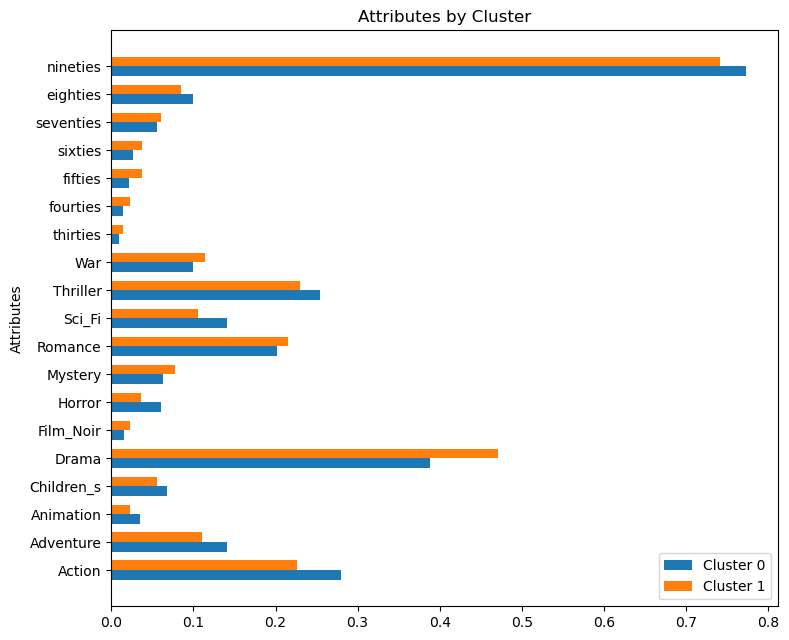

In [24]:
#remove genres that are ns
labels = labels.drop([5, 6, 7, 9, 12, 18])

clus0 = df_clus_mean_genre['Cluster_0'].tolist()
for i in [17, 11, 8, 6, 5, 4]:
    del clus0[i]

clus1 = df_clus_mean_genre['Cluster_1'].tolist()
for i in [17, 11, 8, 6, 5, 4]:
    del clus1[i]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots()
fig.set_size_inches(8, 6.5)
rects1 = ax.barh(x - width/2, clus0, width, label='Cluster 0')
rects2 = ax.barh(x + width/2, clus1, width, label='Cluster 1')
#Formatting of axes
ax.set_ylabel('Attributes')
ax.set_title('Attributes by Cluster')
ax.set_yticks(x, labels)
ax.legend()
fig.tight_layout()
plt.show()

The three biggest differences are the following: The second cluster (35% of users) watches more **drama, war**, and **mystery**, while the first cluster (65% of the customer base) watches more **action, sci fi**, and **thriller**, as well as **more recently released** movies.  
Now that we figured out the major differences of consumption behavior of the two target groups, let's explore WHO the target groups are by comparing their demographic information. Once again, I test for significance of differences first and visualize significant attributes afterwards.

In [25]:
labels = df_clus_mean_demogr['Attribute'].drop(49).append(pd.Series(['gender_F', 'age']))
for attr in labels:
    summary, results = rp.ttest(group1= df_clus[attr][df_clus['Clus_km'] == 0], group1_name= "Cluster 0",
                                group2= df_clus[attr][df_clus['Clus_km'] == 1], group2_name= "Cluster 1")
    if results.at[3, 'results'] < 0.05:
        print("t-test for",attr,":")
        display(results.iloc[0:4])
        

t-test for occupation_administrator :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0520
1,Degrees of freedom =,941.0000
2,t =,-2.7612
3,Two side test p value =,0.0059


t-test for occupation_doctor :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0118
1,Degrees of freedom =,941.0000
2,t =,-2.0162
3,Two side test p value =,0.0441


t-test for occupation_educator :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.1188
1,Degrees of freedom =,941.0000
2,t =,-5.8880
3,Two side test p value =,0.0000


t-test for occupation_executive :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0267
1,Degrees of freedom =,941.0000
2,t =,-2.1622
3,Two side test p value =,0.0309


t-test for occupation_healthcare :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0249
1,Degrees of freedom =,941.0000
2,t =,-2.8425
3,Two side test p value =,0.0046


t-test for occupation_librarian :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0420
1,Degrees of freedom =,941.0000
2,t =,-2.7344
3,Two side test p value =,0.0064


t-test for occupation_retired :


/opt/conda/lib/python3.7/site-packages/researchpy/ttest.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (group1.mean() - group2.mean()) / group1.std()
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-0.0422
1,Degrees of freedom =,941.0000
2,t =,-5.1810
3,Two side test p value =,0.0000


t-test for occupation_student :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,0.3068
1,Degrees of freedom =,941.0000
2,t =,11.8812
3,Two side test p value =,0.0000


t-test for age :


,Independent t-test,results
0,Difference (Cluster 0 - Cluster 1) =,-21.6107
1,Degrees of freedom =,941.0000
2,t =,-48.8732
3,Two side test p value =,0.0000


Some professions are significantly differently represented in the two target groups, which will be visualized in the following. Interestingly, the **age** ist different for the target groups, with cluster 0 (65% of users) being the younger group and cluster 1 (35% of users) constituting of older customers. Furthermore, **gender** is evenly distributed in both target groups, as well as the **rating** - neither group is more generous in its ratings.

Note: the error for retirement occurs as we don't have any retired people in cluster one.

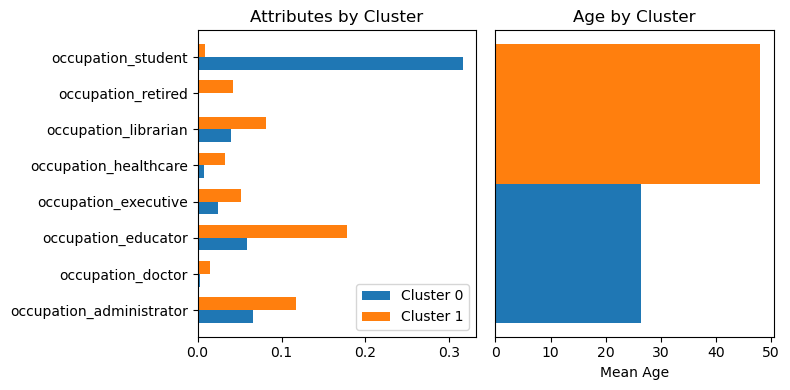

In [26]:
#remove genres that are ns
labels = df_clus_mean_demogr['Attribute'].drop([29, 32, 33, 36, 37, 39, 40, 41, 42, 44, 45, 47, 48, 49])

clus0 = df_clus_mean_demogr['Cluster_0'].tolist()
for i in [21, 20, 19, 17, 16, 14, 13, 12, 11, 9, 8, 5, 4, 1]:
    del clus0[i]
clus1 = df_clus_mean_demogr['Cluster_1'].tolist()
for i in [21, 20, 19, 17, 16, 14, 13, 12, 11, 9, 8, 5, 4, 1]:
    del clus1[i]

fig = plt.figure()
fig.set_size_inches(8, 4)
fig.subplots_adjust(hspace=0.5, wspace=0.4)

ax1 = fig.add_subplot(1, 2, 1)
x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars
rects1 = ax1.barh(x - width/2, clus0, width, label='Cluster 0')
rects2 = ax1.barh(x + width/2, clus1, width, label='Cluster 1')
ax1.set_title('Attributes by Cluster')
ax1.set_yticks(x, labels)
ax1.legend()
fig.tight_layout()

ax2 = fig.add_subplot(1, 2, 2)
x = 1
width = 0.35
rects1 = ax2.barh(x - width/2, df_clus_mean.at[19, 'Cluster_0'], width, label='Cluster 0')
rects2 = ax2.barh(x + width/2, df_clus_mean.at[19, 'Cluster_1'], width, label='Cluster 1')
ax2.set_xlabel('Mean Age')
ax2.set_title('Age by Cluster')
plt.tick_params(left = False, right = False , labelleft = False)
fig.tight_layout()


plt.show()

Especially the group of **students** is represented differently in the two clusters - in the first cluster (65% of the users) they represent more than one third of the people!  
The other professions are more strongly represented in the second target group. This could be mainly due to the fact that cluster 0 represents the young (mean age of 26) and cluster 1 the older customer base (mean age of 48). Professions such as educator or doctor can only be practiced by a certain age due to the long educational path, and professions such as librarian might be more typical and popular in the older generation.

We already know plenty: We identified two different target groups, explored popular movie genres on profile and watch-event level. As a last step, we should look at the frequency with which the two target groups watch certain genres. That's what the following density plots are for. The further the curves are shifted to the right, the more often users watch films from this genre.

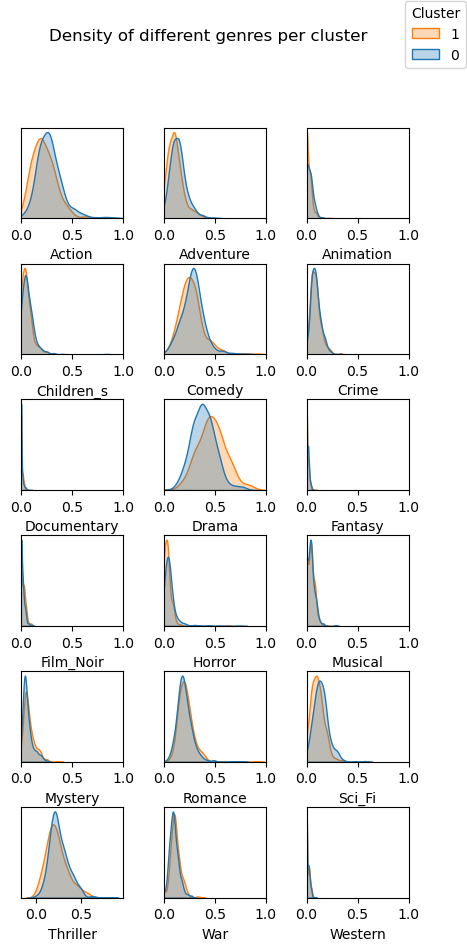

In [27]:
fig = plt.figure()
fig.set_size_inches(5, 10)
fig.subplots_adjust(hspace=0.5, wspace=0.4)
ax = fig.add_subplot(6, 3, 1)
sns.kdeplot(
       data=df_clus, x="Action", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax, legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 2)
sns.kdeplot(
       data=df_clus, x="Adventure", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 3)
sns.kdeplot(
       data=df_clus, x="Animation", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 4)
sns.kdeplot(
       data=df_clus, x="Children_s", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 5)
sns.kdeplot(
       data=df_clus, x="Comedy", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 6)
sns.kdeplot(
       data=df_clus, x="Crime", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 7)
sns.kdeplot(
       data=df_clus, x="Documentary", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 8)
sns.kdeplot(
       data=df_clus, x="Drama", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 9)
sns.kdeplot(
       data=df_clus, x="Fantasy", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 10)
sns.kdeplot(
       data=df_clus, x="Film_Noir", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 11)
sns.kdeplot(
       data=df_clus, x="Horror", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 12)
sns.kdeplot(
       data=df_clus, x="Musical", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 13)
sns.kdeplot(
       data=df_clus, x="Mystery", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 14)
sns.kdeplot(
       data=df_clus, x="Romance", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 15)
sns.kdeplot(
       data=df_clus, x="Sci_Fi", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 16)
sns.kdeplot(
       data=df_clus, x="Thriller", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])

ax = fig.add_subplot(6, 3, 17)
sns.kdeplot(
       data=df_clus, x="War", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(6, 3, 18)
sns.kdeplot(
       data=df_clus, x="Western", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
warnings.filterwarnings("ignore")
#add global title
fig.suptitle('Density of different genres per cluster')

#generate one global legend
fig.legend(df_clus['Clus_km'],     # The line objects
           labels=[1, 0],
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Cluster"  # Title for the legend
           )

plt.show()

**Thrillers** seem to be popular, especially among the younger target group. Movies from the **drama** genre are the most popular, especially with the older target group.  
What also stands out is that while **action** movies are frequently watched, the utility scores were below average, so the rating for these films is particularly poor. 

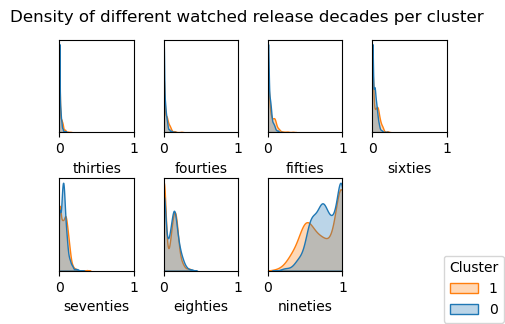

In [28]:
#Same for release decade

fig = plt.figure()
fig.set_size_inches(5, 3)
fig.subplots_adjust(hspace=0.5, wspace=0.4)
ax = fig.add_subplot(2, 4, 1)
sns.kdeplot(
       data=df_clus, x="thirties", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax, legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(2, 4, 2)
sns.kdeplot(
       data=df_clus, x="fourties", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(2, 4, 3)
sns.kdeplot(
       data=df_clus, x="fifties", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
ax.set(xlim=(0, 1))
ax = fig.add_subplot(2, 4, 4)
sns.kdeplot(
       data=df_clus, x="sixties", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(2, 4, 5)
sns.kdeplot(
       data=df_clus, x="seventies", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(2, 4, 6)
sns.kdeplot(
       data=df_clus, x="eighties", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
ax = fig.add_subplot(2, 4, 7)
sns.kdeplot(
       data=df_clus, x="nineties", hue="Clus_km",
       fill=True, common_norm=False,
       alpha=.3, linewidth=1, ax=ax,legend=False).set(ylabel=None, yticklabels=[], yticks=[])
plt.xlim(0, 1)
warnings.filterwarnings("ignore")
#add global title
fig.suptitle('Density of different watched release decades per cluster')

#generate one global legend
fig.legend(df_clus['Clus_km'],
           labels=[1, 0],
           loc="lower right",
           borderaxespad=0.1, 
           title="Cluster"
           )

plt.show()

Looking at the decades, more recent movies are more frequently watched, especially by the younger customers. Yet, the conjoint analysis revealed that older movies were on average rated better.

<h2>Conclusion</h2>
After exploring the question under different approaches, we can summarize some recommendations that can be made when considering the pattern of findings as a whole. Consistent findings are usually the most robust, so they represent the benchmarks and key findings. Based on these key findings, the company is now in a position to make informed decisions about which films to include to expand its streaming offering.


<h3>Recommendation</h3>

The profile combinations of genres that went down well were, of course, one of a kind - Star Wars, The Godfather I and II and Casablanca. If there are similar movies that the provider does not yet offer, it should include them. Otherwise, the expansion of the offering should be geared more to the single attributes.
The key findings of these analyses are briefly presented below, followed by recommendations for action.
<h4>The Leader:</h4>

- **Drama** - This genre is well liked and well rated, especially among the older target group

<h4>Runners-up:</h4>

 - **Sci Fi** - much seen and rated well, especially in the younger demographic.
 - **Thriller** - much watched, especially in the younger group, also did well in watch-event based conjoint
    
<h4>The Allrounders:</h4>

- **Comedy** - this genre always seems to do well, is popular, but was only successful in the profile level conjoint.
- **Adventure** is watched a lot and had good utility scores in profile level conjoint, too

<h4>The Underdogs:</h4>

- **Romance** - these movies are watched frequently and rated well by both target groups
- **War** movies achieve good utility scores and are watched more often by the older target group

<h4>The Looser:</h4>

- **Action** movies are often watched, especially in the young target group, but are poorly rated. Here, special attention could be paid to adding films to the lineup that also cover better-rated genres at the same time.



Particularly movies in the **drama** genre seem to be promising candidates for expanding the range. Potentially, it could be taken into account that the **older target group** watches these films somewhat more often, so that topics could be selected that are muchly appealing to this age group. However, this should not be the exclusive focus, as drama is also the most frequently watched genre among **younger people** and they make up **two-thirds of the customer base** after all.

To further engage the **young target group**, new movies from the **thriller** and **sci fi** genres should also be included. Here, consideration should be given to selecting films that also serve the **comedy and/or adventure** categories, as these enjoy broad popularity.

The secret favorites for the expansion of the offer, which only emerged when looking at the overall picture, are movies from the **romance** and **war** genres. The streaming provider should definitely expand these categories when selecting further movies.

Regarding the **release date**, it turned out that especially older movies are rated well, but newer movies are watched more often. The company could consider **promoting older movies** in its marketing and presentation on the portal to make them more attractive for users.

In terms of advertising and attracting new customers, it is also recommended that the streaming provider designs a **targeted advertising** campaign and/or enticing offers for **students**, as they make up 20% of the whole customer base.


<h3>Limitations</h3>
It is only possible to make conclusions about what contributes to movies being well rated, not what makes them popular. This is not necessarily the same, since well-rated movies are not inevitably watched particularly often or by many users. In addition, the dataset only contains data up to the 1990s, so practical implications and recommendations for action for films since 2000 are impossible to infer.